# From Scratch: Bayesian Inference, Markov Chain Monte Carlo and Metropolis Hastings, in python

In one of the courses during my data science degree, I came across a technique called Markov Chain Monte Carlo, or as it's more commonly referred to, MCMC. The description for this method stated something along the lines of: MCMC is a class of techniques for sampling from a probability distribution and can be used to estimate the distribution of parameters given a set of observations.

Back then, I did not think much of it. I thought, "oh it's just another sampling technique", and I decided I'd read on it when I'd practically need it. This need never emerged, or perhaps it did and I wrongly used something else.

## So why the interest now?

Recently, I have seen a few discussions about MCMC and some of its implementations, specifically the Metropolis-Hastings algorithm and the PyMC3 library. $Markov \: Chain\: Monte\: Carlo\: in\: Python\: - \:A \:Complete\: Real$-$World \:Implementation$ was the article that caught my attention the most. In it, William Koehrsen explains how he was able to learn the approach by applying it to a real world problem: to estimate the parameters of a logistic function that represents his sleeping patterns.


\begin{equation} P(sleep/t,\alpha,\beta)=\dfrac{1}{1+e^{\beta t + \alpha}}  \end{equation}


Mr. Koehrsen uses the PyMC3 implementation of the Metropolis-Hastings algorithm to estimate $\beta$ and $\alpha$, thus computing the entire parameter space, and deriving the most likely logistic model.

## So why am I talking about all that?

I this article, I propose to implement from scratch, my own version of the Metropolis-Hastings algorithm to find parameter distributions for a dummy data example and then of a real world problem.

I figured that if I get my hands dirty, I might finally be able to understand it. I will only use numpy to implement the algorithm, and matplotlib to draw pretty things. Alternatively, scipy can be used to compute the density functions, but I will also show how to implement them using numpy.

## Flow of the article:

    * At first, I will introduce Bayesian inference, MCMC-MH and their mathematical components.
    * Second, I will explain the algorithm using dummy data.
    * Third, I will apply it to a real world problem.

# Part 1: Bayesian inference, Markov Chain Monte Carlo, and Metropolis-Hastings

## A bird's eye view on the philosophy of probabilities

为了谈论贝叶斯推理及其后续内容，我将首先解释贝叶斯概率观是什么，并将其置于其历史背景下


### Frequentist vs Bayesian thinking

对概率有两种主要的解释：贝叶斯学派和频率学派。

从**频率学派**的角度来看，概率表示事件发生的长期频率。 频率学派可以说，**从长期来看**，抛硬币出现反面的概率等于 0.5。 每个新实验都可以被视为同一实验的可能重复的无限序列之一。 这个想法是说，从频率学派来看，信念（belief）是不存在的。事件$x$在$n$次实验中发生的概率等于$P(x)=\frac{n_x}{n}$，当$n\to \infty$时就得到真实的概率。频率学派的学者不会说“我45%（0.45）确信今天午餐有烤宽面条”，因为从长远来看这是不会发生的。通常，频率学派学者的方法被称为客观方法，因为其中没有表达信念和/或先验事件。

另一方面，在贝叶斯学派看来，概率被视为一种信念的表达。 因此，贝叶斯学派的学者会说“我 50% (0.5) 确定今天午餐有千层面”是完全合理的。 通过结合先前的信念和当前事件（证据），我们可以计算后验，即今天有千层面的信念。 贝叶斯学派背后的想法是，信念会随着更多证据的出现而不断被更新。 由于这种方法处理的是信念，因此通常被称为概率的主观观点（主观概率）。

### Bayesian inference


<img src="data/Thomas-Bayes.jpg" style="width: 400px;"> $\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $  *A supposed portrait of Thomas Bayes, an English statistician, philosopher, and theologian. Image Credit: [Farnam Street](https://fs.blog/2018/09/bayes-theorem/).*

在决策哲学中，贝叶斯推断与贝叶斯概率密切相关，因为它利用先验（priors），证据（evidence）和似然（likelihood）来计算后验（posterior）。例如，给定事件B，事件A发生的概率是多少？答案由贝叶斯公式给出：$P(A/B)=\dfrac{P(B/A)P(A)}{P(B)}$


* $P(A/B)$ 为 **后验（posterior）**。 它是我们希望计算得到的。

* $P(B/A)$ 为 **似然（likelihood）**。在A发生的情况下，B发生的可能性。

* $P(A)$ 为 **先验（prior）**。不考虑证据的情况下，事件A发生的可能性。

* $P(B)$ 为 **证据（evidence）**。不考虑事件，证据B发生的可能性。 

在我们的例子中，我们最感兴趣的是如下贝叶斯公式的具体表述：


$P(\theta/D)=\dfrac{P(D/\theta)P(\theta)}{P(D)}$ 其中, $P(\theta/D)$ 为 **后验**, $P(D/\theta)$ 为 **似然**, $P(\theta)$ 为 **先验** , $P(D)$ 为 **证据**.

我们想找到 $\theta$ 的最可能分布，即解释数据$D$的模型的参数。


计算其中一些概率可能很烦，尤其是证据 $P(D)$。 此外，还可能出现其他问题，例如确保共轭（conjugacy）的问题，我不会在本文中深入探讨。 幸运的是，一些技术，即 MCMC，允许我们从后验采样，并得到参数的分布，而不必担心证据的计算，也不必考虑共轭。


### Markov Chain Monte Carlo

MCMC 允许我们从任何无法直接采样的分布中抽取样本。 它可用于从参数的后验分布中采样。
它在许多应用中取得了很大的成功，例如在给定一组观察结果和一些先验信念的情况下计算参数的分布，以及计算物理学和数字通信中的高维积分。


Bottom line: **It can be used to compute the distribution over the parameters, given a set of observations and a prior belief.**

### Metropolis-Hastings

MCMC 是一类方法。 Metropolis-Hastings 是 MCMC 的具体实现。 与 Gibbs 采样和拒绝采样相反，它在高维空间中运行良好。

这种技术需要一个简单的分布  $Q(\theta^\prime/\theta)$，称为提议分布**proposal distribution**（我喜欢称之为过渡模型**transition model**），来从一个难解的后验分布$P(\Theta=\theta/D)$中采样。

Metropolis-Hastings 使用 $Q$ 在分布空间中随机游走，根据样本的可能性接受或拒绝跳转到新位置。 这种“无记忆”的随机游走是 MCMC 的“马尔可夫链”部分。

每个新样本的“似然”由函数 $f$ 决定。 这就是为什么 $f$ 必须与我们要从中采样的后验成正比。 $f$ 通常被选择为表示这种比例的概率密度函数。

为了得到一个组新的参数，只需基于当前参数 $\theta$，利用 $Q(\theta^\prime/\theta)$ 随机采样，得到新的参数 $\theta^\prime$ 。例如，均值为 $\theta$ ，标准差为 $\sigma$ 的正态分布： $Q(\theta^\prime/\theta) = \mathcal{N}(\theta, \sigma)$

为了判断是接受还是拒绝 $\theta^\prime$ ，必须为每个新的 $\theta^\prime$ 计算比率：$\dfrac{P(\theta^\prime/D)}{P(\theta/D)}$ 。利用贝叶斯公式变换为：$\dfrac{P(D/\theta^\prime)P(\theta^\prime)}{P(D/\theta)P(\theta)}$ （证据 $P(D)$ 被消掉）$\dfrac{P(D/\theta^\prime)P(\theta^\prime)}{P(D/\theta)P(\theta)}$ 等于$\dfrac{\prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime)}{\prod_i^nf(d_i/\Theta=\theta)P(\theta)}$


$$\begin{equation} P(\text{accept}) = \begin{cases}\dfrac{\prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime)}{\prod_i^nf(d_i/\Theta=\theta)P(\theta)}, & \prod_i^nf(d_i/\Theta=\theta)P(\theta)>\prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime) \\  1, & \prod_i^nf(d_i/\Theta=\theta)P(\theta)\leq \prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime) \end{cases} \end{equation}$$

这意味着如果 $θ'$ 比当前的 $θ$ 更有可能，那么我们总是接受 $θ'$。 如果它的可能性小于当前的 $θ$，那么我们可能会以似然的比例为概率随机接受或拒绝。

*注意：如果对参数没有偏好或限制，通常会消去先验部分。*


#### Metropolis-Hastings 算法:
* given:
    * $f$, 采样参数的概率密度函数（PDF）
    * $Q$, 过渡模型（transition model）
    * $\theta_0$, 初始 $\theta$
    * $\theta = \theta_0$
    
* for $n$ iterations
    * $p =  f(D/\Theta=\theta)P(\theta)$
    *  $\theta^\prime = Q(\theta_i)$ 
    *  $p^\prime = f(D/\Theta=\theta^\prime)P(\theta^\prime)$ 
    *  $ratio = \dfrac{p^\prime}{p}$ 
    * 从均匀分布中生成随机数 $r$ in [0,1]
    *  if $r<ratio$: 
        * set $\theta_i = \theta^\prime$
                        

In [2]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

# Part 2: 虚拟例子

## Step 1: 生成数据

我们从 $\mu$ = 10， $\sigma$= 3 的正态分布中生成 30,000 个样本，但只有其中的 1000 个可被观察。

9.901522941859275

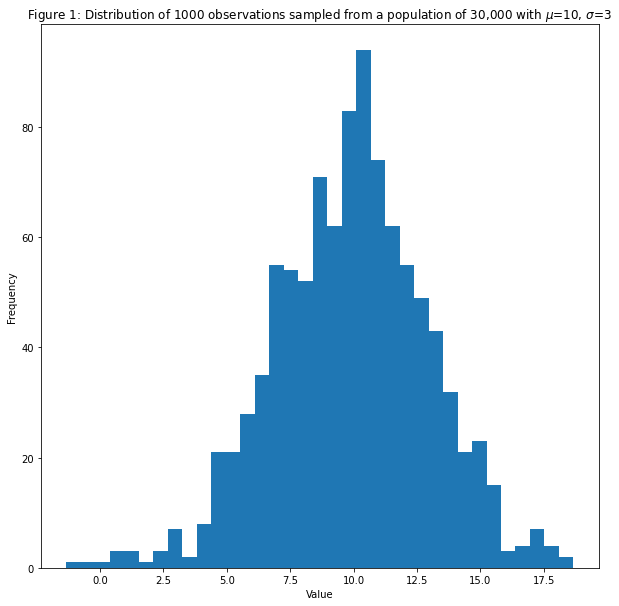

In [3]:
mod1=lambda t:np.random.normal(10,3,t)

# 从均值为10，标准差为3的高斯分布中采样构造30000个数据样本
population = mod1(30000)
# 假设仅能观测到其中的1000个样本
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(observation, bins=35,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

## Step 2: 我们需要什么?

我们希望利用1000个观测数据找到$\sigma_{obs}$的分布。精于数学的人可能会说， $\sigma$ 的计算是有公式的：$\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$)！为什么我们要抽样等等?? 好吧，这只是一个虚拟数据示例，真正的问题在第 3 部分，其中的参数无法直接计算。另外，在这里，我们不是试图找到 $\sigma$ 的值，而是试图计算 $\sigma$ 可能值的分布。


## Step 3: 定义PDF和过渡函数

从图 1 中，我们可以看出数据呈正态分布。 利用 1000 个样本可以很容易地计算出平均值。 这样，我们得到例$\mu_{obs}=9.8$。
【简化起见，这里只用MCMC估计标准差】

### 过渡模型/提议分布:

对于过渡模型，我们没有具体的分布，所以选择一个简单的：正态分布！

\begin{equation} Q(\sigma_{new} / \sigma_{current}) = N(\mu=\sigma_{current},\sigma'=1) \end{equation}

注意 $\sigma'$ 与 $\sigma_{new}$ 和 $\sigma_{current}$ 无关。它只是简单地指定了参数空间的标准差，可以是任何需要的值。 它只影响算法的收敛时间。

### 概率密度函数PDF:

由于 $f$ 应与后验成正比，我们选择 $f$ 为以下概率密度函数 (PDF)，对于数据 $D$ 中的每个数据点 $d_i$：

\begin{equation} f(d_i/ \mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} \end{equation}

在我们的例子中， $\theta$由两个值组成：$[\mu,\sigma]$，$\mu$为常数$\mu = \mu_{obs}$。


## Step 4: 定义接受到是拒绝 $\sigma_{new}$: 

我们接受$\sigma_{new}$，如果满足：


$\dfrac{Likelihood(D/\mu_{obs},\sigma_{new})*prior(\mu_{obs},\sigma_{new})}{Likelihood(D/\mu_{obs},\sigma_{current})*prior(\mu_{obs},\sigma_{current})}>1     \quad \quad \quad \quad \quad      (1)$

如果这个比率小于或等于 1，那么我们将它与 [0,1] 中均匀生成的随机数进行比较。 如果比率大于随机数，我们接受 $\sigma_{new}$，否则我们拒绝它。

*注意：由于我们将计算这个比率来决定应该接受哪些参数，因此必须确保采用的函数 $f$ 与后验本身$P(\sigma/ D,\mu)$ 成正比，在本例中已得到验证。 ($f$ 是 P 的 PDF)*


## Step 5: 定义先验和似然

### 先验 $P(\theta)$ 可用$P(\sigma)$代替，因为 $\mu$ 为常数:

我们对 $\sigma_{new}$ 和 $\sigma_{current}$ 可以采用的值没有任何偏好。 唯一值得注意的是，他们应该是正值。 为什么？ 直观地说，标准差衡量的是离差。数学上，$\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$，一个数的平方根不能为负数。 我们在事先严格执行这一点。


### 似然 

一组观察值 $D$ 的总似然为：$Likelihood(D/\mu_{obs},\sigma_{a}) = \prod_i^n f(d_i/\mu_{obs},\sigma_{a}) $，其中 $a=new \: or \: current$。

在我们的例子中，我们对先验函数和似然函数取对数。 为什么要取对数？ 仅仅是因为它有助于数值稳定性，即乘以数千个较小的值（概率、可能性等）会导致系统内存下溢，而取对数是一个完美的解决方案，因为它将乘法转换为加法并将小的正数转换为不那么小的负数。


因此，我们基于式 $(1)$ ，得到的接受条件为：


如果满足下式则接受 $\sigma_{new}$:

$\quad \quad \quad \quad \quad Log(Likelihood(D/\mu_{obs},\sigma_{new})) + Log(prior(\mu_{obs},\sigma_{new})) - (Log(Likelihood(D/\mu_{obs},\sigma_{current}))+$

$Log(prior(\mu_{obs},\sigma_{current})))>0$

$\quad$

 Equivalent to:
 
 $\sum_i^nLog(f(d_i/\mu_{obs},\sigma_{new})) + Log(prior(\mu_{obs},\sigma_{new})) - \sum_i^nLog(f(d_i/\mu_{obs},\sigma_{current}))-Log(prior(\mu_{obs},\sigma_{current}))>0$
 
 $\quad$
 
 
  Equivalent to:
  
  $\sum_i^nLog(f(d_i/\mu_{obs},\sigma_{new})) + Log(prior(\mu_{obs},\sigma_{new})) > \sum_i^nLog(f(d_i/\mu_{obs},\sigma_{current}))+Log(prior(\mu_{obs},\sigma_{current}))$
  
   $\quad$
  
  Equivalent to: 
  
  $\sum_i^n -nLog(\sigma_{new}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{new}^2} + Log(prior(\mu_{obs},\sigma_{new})) \quad > $
  
 $ \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad(2)$
 $ \quad \quad \quad \quad \quad \sum_i^n -nLog(\sigma_{current}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{current}^2}+Log(prior(\mu_{obs},\sigma_{current}))  $
  
  
  通过从对数中取出平方根和乘法，可以对上式进一步简化。

In [4]:
# tranistion model 定义了如何从 sigma_current 到 sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

## Step 6: 使用初始参数运行算法并收集接受和拒绝的样本

In [5]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)

In [6]:
len(accepted), len(rejected)

(8468, 41532)

### 接受和拒绝样本分析

算法接受了8468个$\sigma$的样本（每次每行结果可能不同），最后10个样本的值为：

In [7]:
accepted[-10:,1]

array([3.00768879, 3.00895995, 2.98154922, 3.07620254, 3.05175018,
       2.97509239, 2.93066518, 3.05339625, 2.91883224, 2.86502796])

In [8]:
print(accepted.shape)

(8468, 2)


(8468, 2)

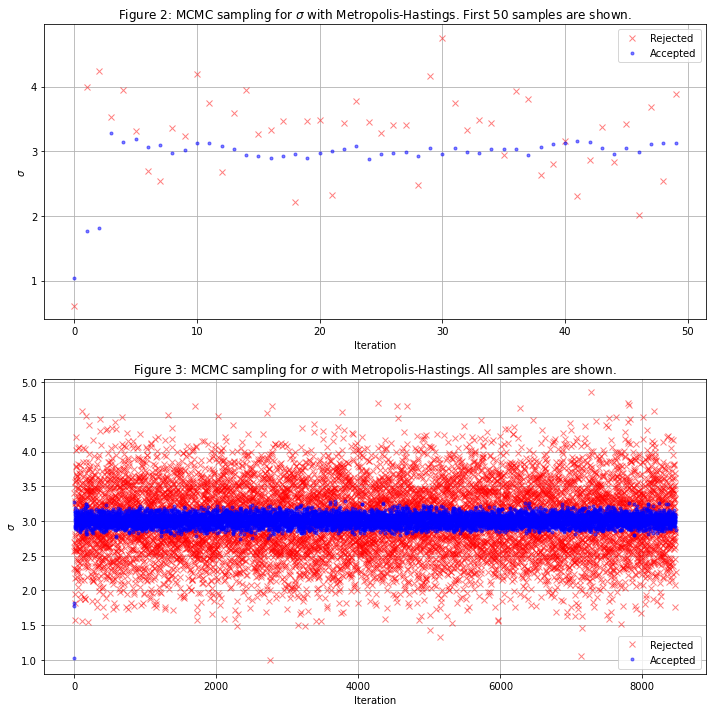

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

因此，从初始为 0.1 的 σ 开始，算法很快收敛到预期值 3。也就是说，它只是在一维空间中采样……。 所以这并不奇怪。

### 最初 25% 的 𝜎 值视为“burn-in”，因此将其丢弃

### 可视化 𝜎 的迹线和迹线的直方图

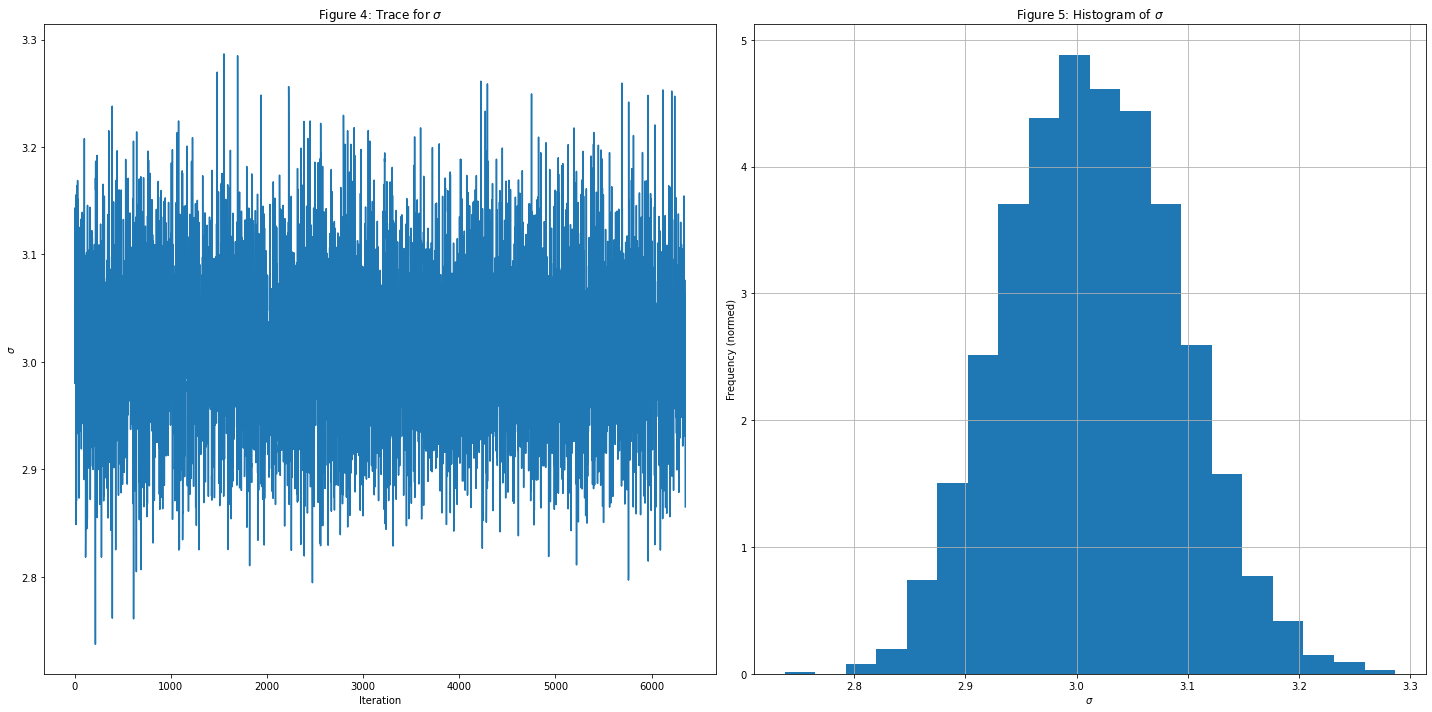

In [10]:

show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()


ax.grid("off")


### 结果

$\sigma$最可能的值约为 3.。 多次运行可能会与 3.0 有少许差别。 原因是我们只观察了原始数据的 3.33%（30,000 个样本中的 1,000 个）

## 预测

首先，我们对 σ 的后 75% 接受样本进行平均，然后我们从 μ=9.8 和 σ=3.0（后 75% 接受样本的平均值）的正态分布中生成 30,000 个随机个体。

9.901522941859273 3.014757912619972


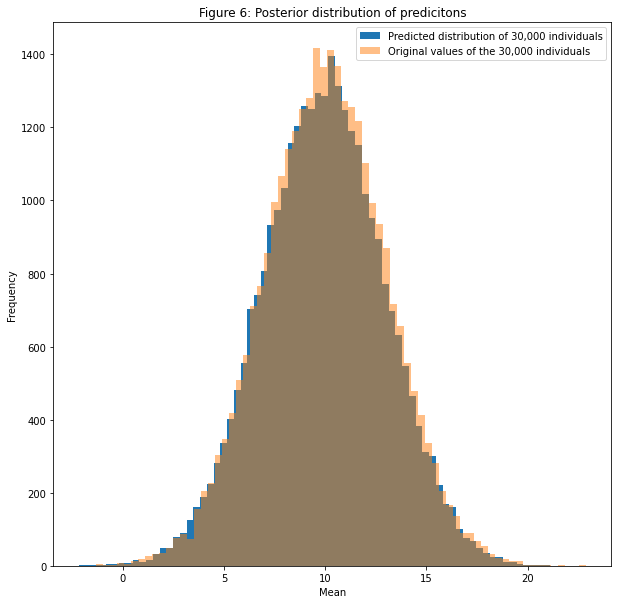

In [12]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()

# Part 3: 实例

<img src="data/Sunspot1.jpg">*Credit: Amateur astronomer Alan Friedman on July 10, 2012.*

太阳黑子是太阳表面（光球层）上的一个区域，其特征是温度低于其周围环境。 这些降低的温度是由磁场通量集中引起的，磁场通量集中通过类似于[涡流制动器](https://en.wikipedia.org/wiki/Eddy_current)的效果抑制对流。 太阳黑子通常成对出现相反的磁极。 它们的数量根据大约 11 年的太阳活动周期而变化。

我们将处理的数据是从 1749 年 1 月到 2018 年 11 月的每个月的“每月平均太阳黑子总数”。这是[世界数据中心](http://www.sidc.be/silso/home)收集、整理和公开的数据，用于制作、保存和传播国际太阳黑子数。

## 太阳黑子数可视化

让我们绘制多年来的数据，看看分布情况。

(3238,) (3238,)
1785.042


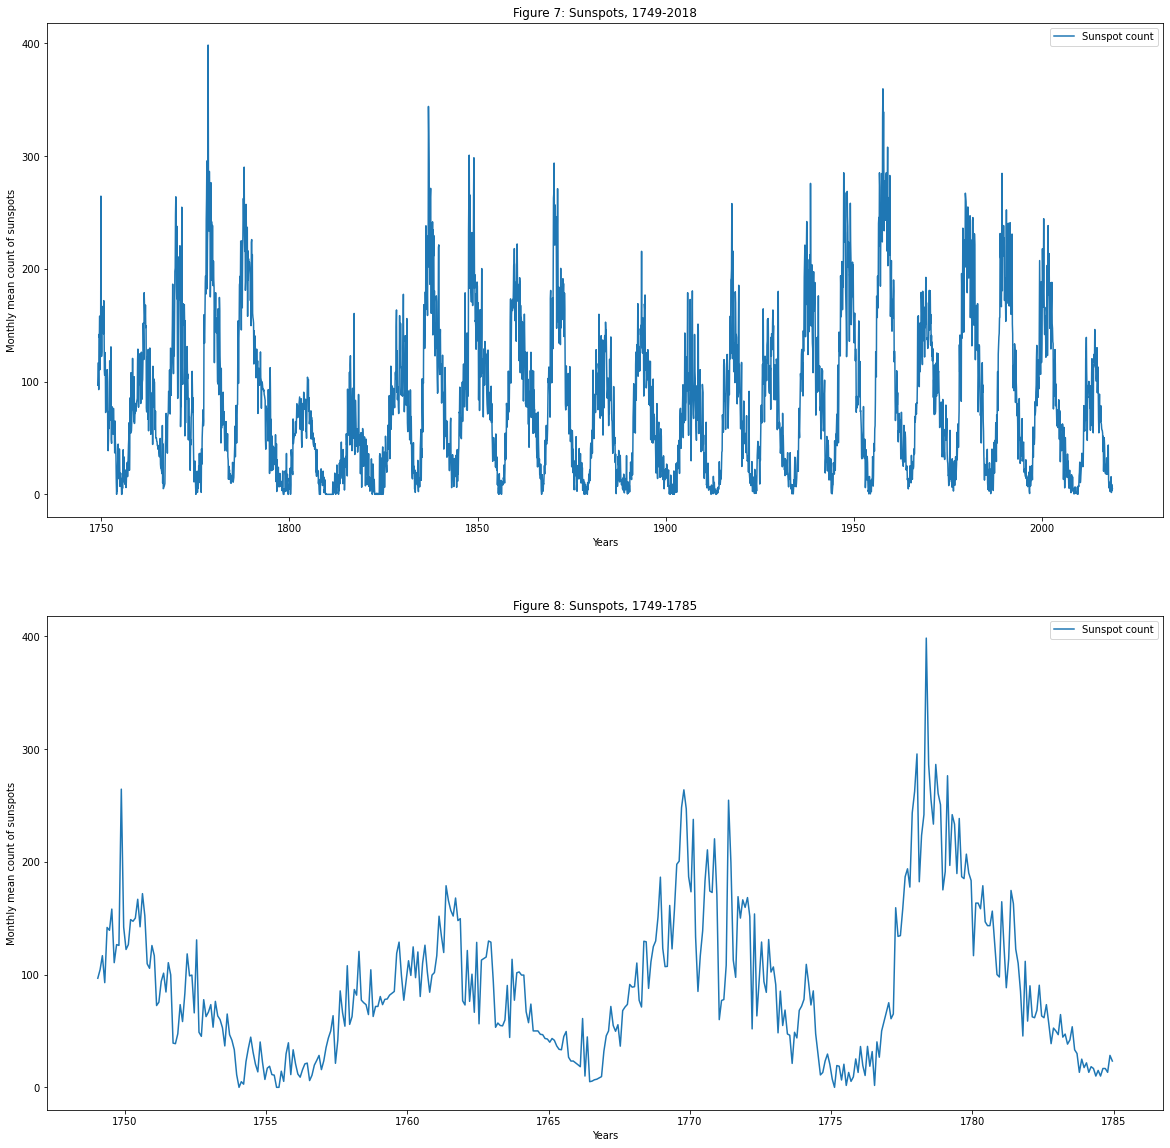

In [13]:
sunspots = np.loadtxt("data/SN_m_tot_V2.0.csv", delimiter=';')

#years is the third column
years = sunspots[:,2]
#activity is the 4th column
activity = sunspots[:,3] + 0.1
print(years.shape,activity.shape)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(2,1,1)

ax.plot(years, activity, label="Sunspot count")
ax.set_yticks(np.arange(0,500,100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 7: Sunspots, 1749-2018")
ax.legend()


ax = fig.add_subplot(2,1,2)
print(years[432])
ax.plot(years[:432], activity[:432], label="Sunspot count")
ax.set_yticks(np.arange(0,500,100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 8: Sunspots, 1749-1785")
ax.legend()

## 数据模型

从数据看起来，我们可以用伽马分布对这种现象进行建模，每 12 年一个新周期。

伽马分布 Γ 是连续概率分布的双参数族，参数是形状 a 和尺度 b。 伽马分布的随机变量 X 记为 X~Γ(a, b)，在我们的例子中，X 是太阳黑子的数量。 两个参数 a 和 b 是我们要计算分布的未知数。

<img src="data/gamma.PNG">*Credit: Wikipedia Commons.*

例如，在第一个周期中，太阳黑子数量从 1749 年底的最高值约 300 开始，然后在 6 年后的 1755 年下降到最低值。然后该数字再次上升到 1761 年和之前的 1762 年的最大值，在 1766 年再次下降，依此类推......
 

## 太阳黑子数量直方图

Text(0.5, 1.0, 'Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)')

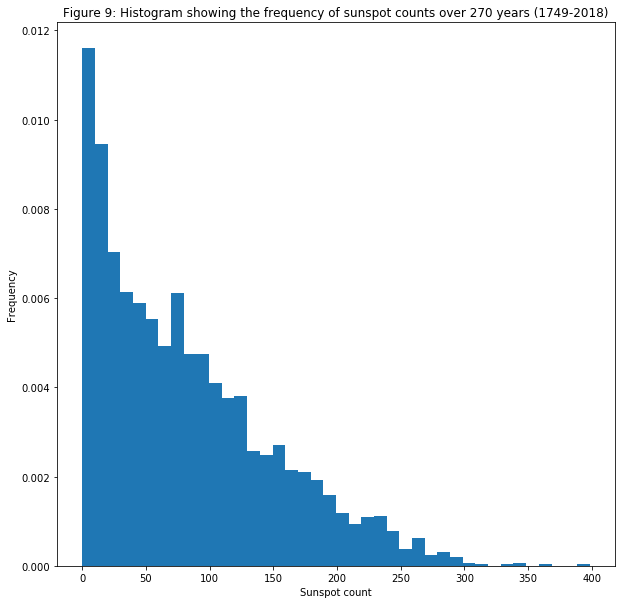

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(activity, bins=40, density=True)
ax.set_xlabel("Sunspot count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)")

## 计数的频率似乎确实遵循伽马分布

伽马分布的PDF为$f/f(x;a,b) =\dfrac{b^a x^{a-1}e^{-b x}}{\Gamma{(a)}}$，其中$\Gamma$为伽马函数，$\Gamma{(a)}=(a-1)!$。

按照与虚拟数据示例中相同的过程，我们可以写出此 PDF 的对数似然（请参见下面的代码）。 或者，可以使用 `scipy.stats.gamma(a,b).pdf(x)` 函数来计算。

由于 a 和 b 必须为正，我们在先验中强制执行此操作。

In [14]:
transition_model = lambda x: np.random.normal(x,[0.05,5],(2,))
import math
def prior(w):
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1
    
def manual_log_lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))
    
def log_lik_gamma(x,data):
    return np.sum(np.log(scipy.stats.gamma(a=x[0],scale=x[1],loc=0).pdf(data)))    


In [17]:
accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[4, 10], 50000,activity,acceptance)

In [18]:
print(accepted.shape)
accepted[-10:]

(8446, 2)


array([[ 1.01980394, 80.72802272],
       [ 0.973146  , 85.81271741],
       [ 1.00523705, 81.58749452],
       [ 0.95835592, 85.00806401],
       [ 0.97506922, 83.38147929],
       [ 1.00833297, 83.21767739],
       [ 0.95311644, 85.21549196],
       [ 0.96073557, 87.41470703],
       [ 0.94937167, 86.15658977],
       [ 0.94320714, 87.13644186]])

从a=4，b=10开始，算法接受了8446对样本，a的最后一个值为0.94320714，b的最后一个值为87.13644186，与初始值相差甚远。


## 结果分析

Text(0.5, 1.0, 'Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

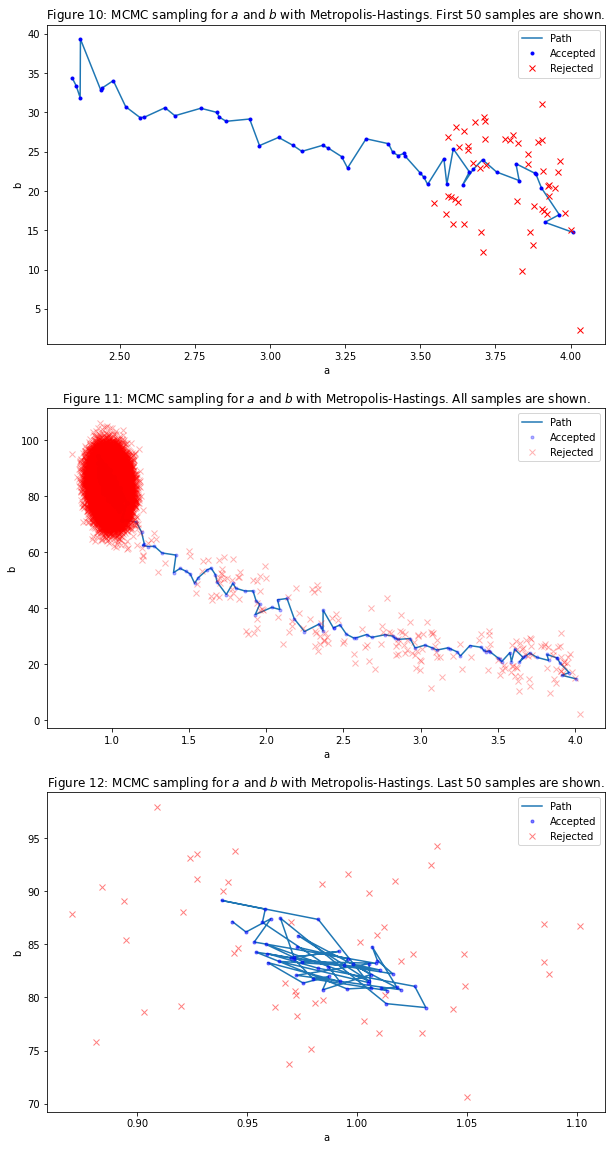

In [19]:

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 10: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 11: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.") 

正如我们从图 10、11 和 12 中看到的那样，该算法快速收敛到 [a=1,b=83] 区域。

提示：当算法开始严重拒绝样本时，这意味着我们已经达到了可能性的饱和区域。 通常，这可以解释为已达到我们可以从中采样的最佳参数空间，即算法几乎没有理由接受新值。 这在图 11 和 12 中标出，其中算法不再接受小范围之外的任何值。

### 将最初50%的值视为"burn-in"并去除

### 可视化 a 和 b 的迹线以及迹线的直方图

Text(0.5, 1.0, '2D histogram showing the joint distribution of $a$ and $b$')

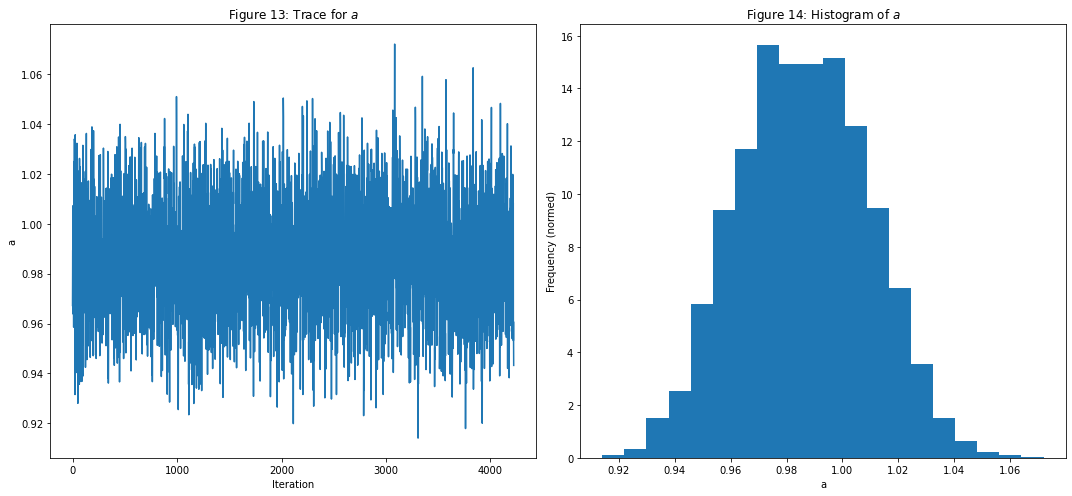

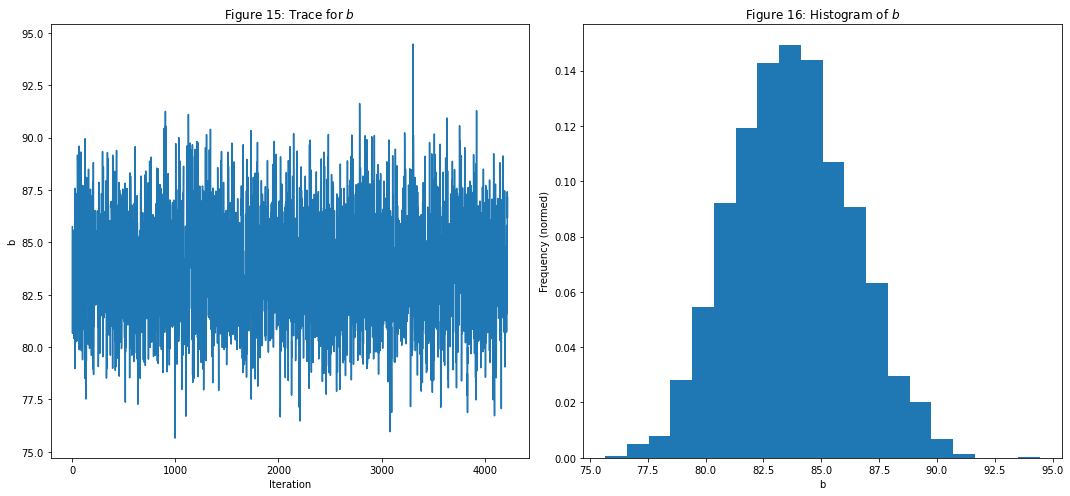

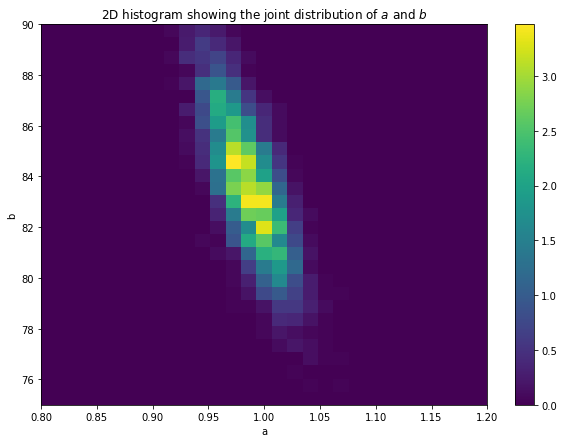

In [20]:
show=int(-0.5*accepted.shape[0])
hist_show=int(-0.50*accepted.shape[0])


fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,0])
ax.set_title("Figure 13: Trace for $a$")
ax.set_xlabel("Iteration")
ax.set_ylabel("a")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,0], bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("a")
ax.set_title("Figure 14: Histogram of $a$")
fig.tight_layout()

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 15: Trace for $b$")
ax.set_xlabel("Iteration")
ax.set_ylabel("b")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("b")
ax.set_title("Figure 16: Histogram of $b$")
fig.tight_layout()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
xbins, ybins = np.linspace(0.8,1.2,30), np.linspace(75,90,30)
counts, xedges, yedges, im = ax.hist2d(accepted[hist_show:,0], accepted[hist_show:,1], density=True, bins=[xbins, ybins])
ax.set_xlabel("a")
ax.set_ylabel("b")
fig.colorbar(im, ax=ax)
ax.set_title("2D histogram showing the joint distribution of $a$ and $b$")

## 预测

首先，我们对 a 和 b 的最后 50% 接受样本进行平均，然后从 Γ 分布中生成随机个体。 $a_{average}$=0.9860918140184449， $b_{average}$=83.74427720088335。

0.9860918140184449 83.74427720088335


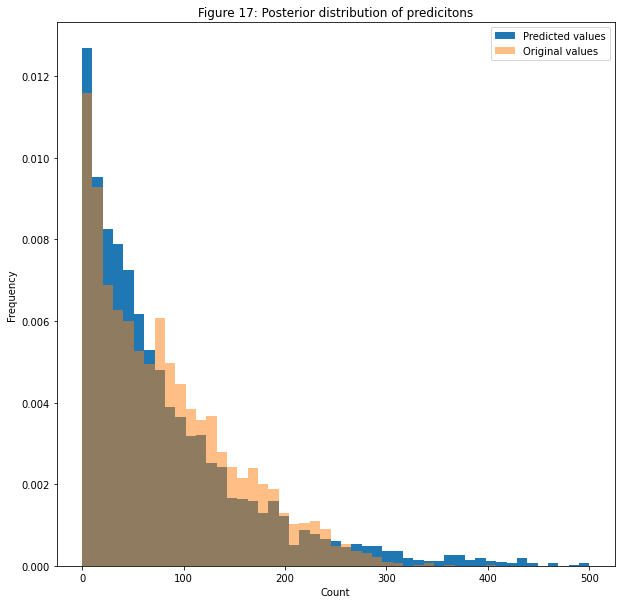

In [21]:
show=-int(0.5*accepted.shape[0])

mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.gamma(mu,sigma,t)
t=np.arange(activity.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)



ax.hist( observation_gen,bins=np.linspace(0,500,50) ,density=True,label="Predicted values")
ax.hist( activity,bins=np.linspace(0,500,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 17: Posterior distribution of predicitons")
ax.legend()

## 评价
### 评估proposal分布

我们如何指定分布 Q 的参数？ 我们应该远离当前样本 θ 还是保持相对接近？ 这些问题可以通过测量接受样本之间的自相关来回答：我们不希望接受样本之间的相关性太高。 我们不希望远距离样本过于相关，因为我们正在尝试实现马尔可夫链，即一个样本应该只依赖于它之前的样本，并且自相关图应该显示样本相关性之间的快速指数下降 i 和 i-1,i-2,...i-n

自相关是通过为每个滞后 $k$ 计算以下函数来定义的:
$r_k=\dfrac{\sum_{i=1}^{N-k}(Y_i-Y_{avg})(Y_{i+k}-Y_{avg})}{\sum_{i=1}^{N}(Y_i-Y_{avg})^2}$

滞后 $k$ 基本上是样本 $Y_i$ 周围的*范围*，我们想在其中测量相关性。

下图显示了 k 从 1 到 100 的 a、b 的自相关。k=1 的滞后意味着我们正在测量样本与其自身的相关性，因此我们期望它等于 1。 k 越高，相关性应该越低。

0.9860918140184449 83.74427720088335


[Text(0.5, 0, 'lag'), Text(0, 0.5, 'autocorrelation'), (-0.1, 1.0)]

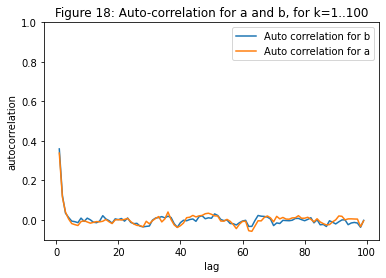

In [22]:
mean_acc_0=accepted[show:,0].mean()
mean_acc_1=accepted[show:,1].mean()
print(mean_acc_0,mean_acc_1)

lag=np.arange(1,100)
def autocorr(accepted,lag):
    num_0=0
    denom_0=0
    num_1=0
    denom_1=0
    for i in range(accepted.shape[0]-lag):
        num_0+=(accepted[i,0]-mean_acc_0)*(accepted[i+lag,0]-mean_acc_0)
        num_1+=(accepted[i,1]-mean_acc_1)*(accepted[i+lag,1]-mean_acc_1)
        denom_0+=(mean_acc_0-accepted[i,0])**2
        denom_1+=(mean_acc_1-accepted[i,1])**2
    rk_0=num_0/denom_0
    rk_1=num_1/denom_1
    return rk_0, rk_1


accepted_reversed=accepted[show:,:]
result=np.zeros((2,lag.shape[0]))
#print(lag)
for l in lag:
    result[:,l-1]=autocorr(accepted_reversed,l)
    
    
###Instead of writing an autocorrelation function, one could simply use thee autocorr function provided in pymc3    
#from pymc3.stats import autocorr

fig, ax = plt.subplots()
#ax.plot(lag, [autocorr(accepted[show:,1], l) for l in lags], label='auto b')
#ax.plot(lag, [autocorr(accepted[show:,0], l) for l in lags], label='auto a')
ax.plot(lag, result[1,:], label='Auto correlation for b')
ax.plot(lag, result[0,:], label='Auto correlation for a')
ax.legend(loc=0)
ax.set_title("Figure 18: Auto-correlation for a and b, for k=1..100")
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))


在我们的例子中，我们很幸运有足够低的相关性。 通常，我们可能希望自动设置proposal分布的参数 Q，一种常见的方法是不断调整proposal参数，以便拒绝超过 50% 的proposal。 或者，可以使用称为 Hamiltonian Monte Carlo 的增强版 MCMC，它可以降低连续采样状态之间的相关性并更快地达到平稳分布。

## 结论

虽然这个算法背后的抽象乍一看似乎难以理解，但实现起来实际上非常简单，而且效果非常好。 事实上，关于概率编程，特别是 MCMC 的伟大之处在于你只需要写下模型然后运行它。无需计算证据，或确保某些约束性数学属性。



## 资料

Peter Driscoll, "A comparison of least-squares and Bayesian fitting techniques to radial velocity data sets" 

Carson Chow, "MCMC and fitting models to data"

John H. Williamson, "Data Fundamentals - Probabilities"

Simon Rogers, "A first course in machine learning"